# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1545      0 --:--:-- --:--:-- --:--:--  1545
100 1546k  100 1546k    0     0  3075k      0 --:--:-- --:--:-- --:--:-- 3075k


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1385      0 --:--:-- --:--:-- --:--:--  1385
100  385k  100  385k    0     0   812k      0 --:--:-- --:--:-- --:--:--  812k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    806      0 --:--:-- --:--:-- --:--:--   806
100  230k  100  230k    0     0   338k      0 --:--:-- --:--:-- --:--:--  338k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip install pyreclab --upgrade
#!pip install seaborn --upgrade

In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [11]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

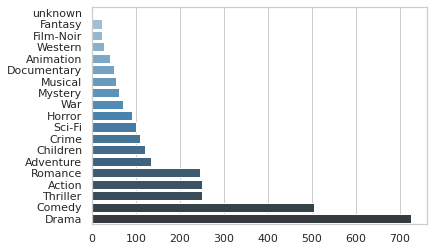

In [12]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:** SVD encuentra una factorización matricial de la matriz de ratings dados por usuarios a items de tal manera que el producto punto de un vector correspondiente a un item con el vector de un usuario sea igual al rating asignado por el usuario a ese item. pyreclab utiliza funk SVD, es decir que aprende los vectores de usuarios e items de manera iterativa haciendo descenso de gradiente para encontrar los vectores que minimicen el error en el rating.

## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [13]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [29]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [30]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.7205477265760835
RMSE: 0.9141292584934216


In [31]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.11411389689350569
NDCG@20: 0.06367492121831737


In [32]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1449, 1512, 169, 1398, 1367, 408, 12, 1639, 483, 480, 1467, 963, 114, 318, 64, 48, 603, 1137, 134, 189]


In [33]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1398,Anna (1996),13-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Anna%20(1996),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1639,Bitter Sugar (Azucar Amargo) (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Bitter%20Suga...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0


Top 5 de recomendaciones

In [34]:
top_n = 5

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.09658839626997451
NDCG@5: 0.05089574518639218


In [35]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1449, 1512, 169, 1398, 1367]


In [37]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking][["title", "release_date"]]

,title,release_date
movieid,,
1449,Pather Panchali (1955),22-Mar-1996
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996
169,"Wrong Trousers, The (1993)",01-Jan-1993
1398,Anna (1996),13-Nov-1996
1367,Faust (1994),01-Jan-1994


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Vamos a buscar los mejores parametros entre los definidos en la siguiente celda

In [ ]:
factor_values = [100, 150, 200]
max_iters = [100, 500, 1000]
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.01, 0.1, 1]
factor_values, max_iters, learning_rates, lambdas = np.meshgrid(factor_values, max_iters, learning_rates, lambdas)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
# Ejemplo
mae_values = np.zeros_like(factor_values, dtype=np.float64) # para almacenar resultados de MAP
rmse_values = np.zeros_like(factor_values, dtype=np.float64) # para almacenar valores de NDCG
with tqdm(total=81) as pbar:
  for i in range(3):
    for j in range(3):
      for k in range(3):
        for l in range(3):
          factors, iters, lr, lamb = factor_values[i, j, k, l], max_iters[i, j, k, l], learning_rates[i, j, k, l], lambdas[i, j, k, l]

          svd.train(factors=factors, maxiter=iters, lr=lr, lamb=lamb)
          
          predlist, mae, rmse = svd.test(input_file='u2.test',
                                        dlmchar=b'\t',
                                        header=False,
                                        usercol=0,
                                        itemcol=1,
                                        ratingcol=2)
          
          mae_values[i,j,k,l] = mae
          rmse_values[i,j,k,l] = rmse
          pbar.update(1)

print(mae_values)
print(rmse_values)

  0%|          | 0/81 [00:00<?, ?it/s]

[[[[0.7461334  0.74336079 0.80336503]
   [0.81030864 0.7205984  0.80575961]
   [0.79720141 0.76450747 0.83435938]]

  [[0.74715356 0.74372746 0.80333651]
   [0.77240785 0.72060936 0.80576252]
   [0.75878301 0.76442897 0.83435938]]

  [[0.74895981 0.74266175 0.80339951]
   [0.75696924 0.72030914 0.80575419]
   [0.75280643 0.76444345 0.83435938]]]


 [[[0.80683403 0.71859904 0.80196451]
   [0.79014119 0.72156637 0.80593447]
   [0.79286825 0.76474791 0.83435938]]

  [[0.78142978 0.71782152 0.80197565]
   [0.75720972 0.72158472 0.80593447]
   [0.75703829 0.76474446 0.83435938]]

  [[0.76804722 0.71842102 0.80200406]
   [0.74763612 0.7213871  0.80593447]
   [0.75556962 0.76474388 0.83435938]]]


 [[[0.80403077 0.71949351 0.80200856]
   [0.78272775 0.72168597 0.80593454]
   [0.79353162 0.76473982 0.83435938]]

  [[0.77462465 0.71877104 0.80202158]
   [0.7532862  0.72165151 0.80593454]
   [0.75692496 0.76476524 0.83435938]]

  [[0.76120755 0.71900744 0.80201363]
   [0.74819202 0.72166899 0.80

In [ ]:
mae_param_indices = np.unravel_index(mae_values.argmin(), mae_values.shape)
rmse_param_indices = np.unravel_index(rmse_values.argmin(), rmse_values.shape)
mae_param_indices, rmse_param_indices

((1, 1, 0, 1), (1, 2, 0, 1))

In [ ]:
factor_mae, max_iters_mae, learning_rate_mae, lambda_mae = factor_values[mae_param_indices], max_iters[mae_param_indices], learning_rates[mae_param_indices], lambdas[mae_param_indices]
factor_mae, max_iters_mae, learning_rate_mae, lambda_mae

(150, 500, 0.001, 0.1)

In [ ]:
factor_rmse, max_iters_rmse, learning_rate_rmse, lambda_rmse = factor_values[rmse_param_indices], max_iters[rmse_param_indices], learning_rates[rmse_param_indices], lambdas[rmse_param_indices]
factor_rmse, max_iters_rmse, learning_rate_rmse, lambda_rmse

(200, 500, 0.001, 0.1)

Los mejores parametros encontrados segun MAE son $factores=150, max\_iters=500, learning\_rate=0.001$ y $lambda=0.1$.
Los mejores parametros encontrados segun RMSE son $factores=200, max\_iters=500, learning\_rate=0.001$ y $lambda=0.1$.

In [38]:
svd.train(factors=200, maxiter=500, lr=0.001, lamb=0.1)
          
predlist, mae, rmse = svd.test(input_file='u2.test',
                              dlmchar=b'\t',
                              header=False,
                              usercol=0,
                              itemcol=1,
                              ratingcol=2)
rmse, mae

(0.9122059767428281, 0.7188827730873891)

In [39]:
top_n = 5

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.11997192562569643
NDCG@5: 0.06975545705088526


In [40]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1449, 1512, 408, 169, 483]


In [41]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking][["title", "release_date"]]

,title,release_date
movieid,,
1449,Pather Panchali (1955),22-Mar-1996
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996
408,"Close Shave, A (1995)",28-Apr-1996
169,"Wrong Trousers, The (1993)",01-Jan-1993
483,Casablanca (1942),01-Jan-1942


El recomendador entrenado en una primera instancia obtuvo 
- MAE: 0.72
- RMSE: 0.914

y el mejor recomendado encontrado ahora obtuvo
- MAE: 0.7188
- RMSE: 0.912

Por lo que es levemente mejor que el anterior. A pesar de este pequeño cambio en las metricas, el top 5 de recomendaciones cambió 2 peliculas. Ya no aparecen las peliculas Anna ni Faust, pero si aparecen A Close Shave y Casablanca, ademas de eso la pelicula The Wrong Trousers estaba en tercer lugar anteriormente y ahora está en cuarto lugar, el top 2 no cambió.

**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



Veamos como varia el RMSE al modificar cada uno de los parametros, pero manteniendo fijos los mejores de los otros parametros

In [21]:
factor_values = [100, 150, 200, 250]
rmse_factor = []
for factors in factor_values:
  svd.train(factors=factors, maxiter=500, lr=0.001, lamb=0.1)
            
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)
  rmse_factor.append(rmse)

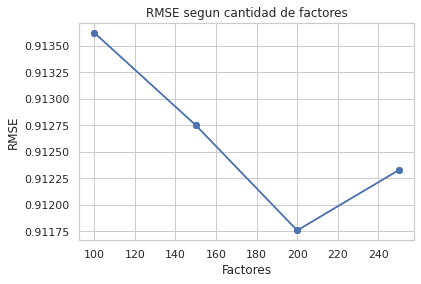

In [42]:
plt.title("RMSE segun cantidad de factores")
plt.ylabel("RMSE")
plt.xlabel("Factores")

plt.plot(factor_values, rmse_factor, 'bo-')
plt.plot(factor_values, rmse_factor, 'bo-')
plt.show()

En un principio un aumento de la cantidad de factores beneficia el rendimiento, pero después lo perjudica, esto probablemente se deba a que para mas factores el algoritmo necesita mas iteraciones para aprenderlos bien.

In [23]:
max_iters = [100, 250, 500, 1000]
rmse_iters = []
for iters in max_iters:
  svd.train(factors=200, maxiter=iters, lr=0.001, lamb=0.1)
            
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)
  rmse_iters.append(rmse)

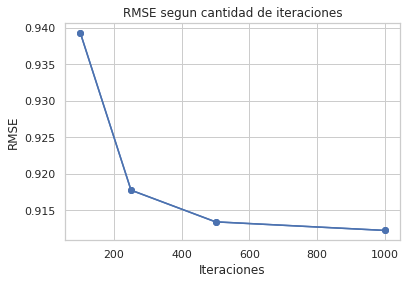

In [43]:
plt.title("RMSE segun cantidad de iteraciones")
plt.ylabel("RMSE")
plt.xlabel("Iteraciones")

plt.plot(max_iters, rmse_iters, 'bo-')
plt.plot(max_iters, rmse_iters, 'bo-')
plt.show()

Como es de esperar, a medida que aumenta la cantidad de iteraciones el rendimiento del recomendador mejora.

In [25]:
lrs = [0.0005, 0.001, 0.01, 0.1]
rmse_lrs = []
for lr in lrs:
  svd.train(factors=200, maxiter=500, lr=lr, lamb=0.1)
            
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)
  rmse_lrs.append(rmse)

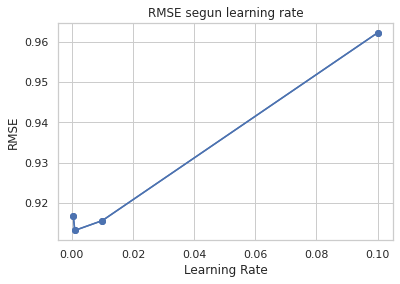

In [44]:
plt.title("RMSE segun learning rate")
plt.ylabel("RMSE")
plt.xlabel("Learning Rate")

plt.plot(lrs, rmse_lrs, 'bo-')
plt.plot(lrs, rmse_lrs, 'bo-')
plt.show()

Se puede ver que learning rates más pequeños tienen un mejor rendimiento, esto probablemente se deba a que de esta manera el algoritmo logra llegar de buena manera a algun optimo o avance en su dirección de manera controlada.

In [27]:
lambdas = [0.01, 0.05, 0.1, 0.5]
rmse_lambdas = []
for lambd in lambdas:
  svd.train(factors=200, maxiter=500, lr=0.001, lamb=lambd)
            
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)
  rmse_lambdas.append(rmse)

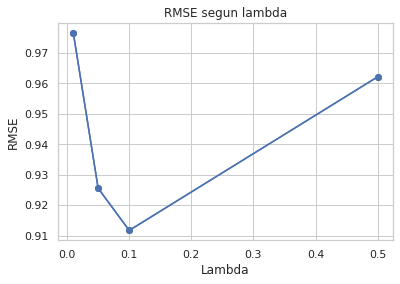

In [45]:
plt.title("RMSE segun lambda")
plt.ylabel("RMSE")
plt.xlabel("Lambda")

plt.plot(lambdas, rmse_lambdas, 'bo-')
plt.plot(lambdas, rmse_lambdas, 'bo-')
plt.show()

Como se puede ver, valores de lambda no tan pequeños pero tampoco grandes tienen un mejor rendimiento, esto se debe a que para bajos lambda el algoritmo puede estar overfitteando el dataset de training y para lambdas grandes la regularización pesa mucho y le cuesta capturar la distribucion de los datos.